In [ ]:
import tensorflow
tensorflow.__version__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Just like the way we did it in class (Module 5- Python 3 notebook), go to the KaggleLinks to an external site. website and download the data. (5 points)

In [ ]:
from google.colab import files
files.upload()
!cat kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d destination_folder


Streaming output truncated to the last 5000 lines.
  inflating: destination_folder/seg_train/seg_train/mountain/7506.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7537.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7539.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7551.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7560.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7565.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7578.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7581.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7586.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7647.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7652.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7654.jpg  
  inflating: destination_folder/seg_train/seg_train/mountain/7662.jpg  
  inflating: 

You need to make the relevant directories (train, validation, test) and copy images from the original directory to this new subdirectories you just created. Make sure you copy 1000 images of each class for the train, 500 for validation and 1000 images for the test data directory. (10 points)

In [ ]:
import os
import shutil
from random import sample

# Define the base directory
base_dir = '/content/destination_folder'

# Define the original and new directories
original_train_dir = os.path.join(base_dir, 'seg_train', 'seg_train')


new_train_dir = os.path.join(base_dir, 'train')
new_val_dir = os.path.join(base_dir, 'validation')
new_test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Create the new directories
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# List of classes
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Function to copy images
def copy_images(orig_dir, new_dir, start_index, num_images):
    for cls in classes:
        cls_dir = os.path.join(orig_dir, cls)
        images = sorted(os.listdir(cls_dir))  # Sort the images
        selected_images = images[start_index:start_index + num_images]

        print(f"Copying {len(selected_images)} images from class '{cls}'...")

        os.makedirs(os.path.join(new_dir, cls), exist_ok=True)
        for img in selected_images:
            src_path = os.path.join(cls_dir, img)
            dest_path = os.path.join(new_dir, cls, img)
            shutil.copy(src_path, dest_path)

        print(f"Done copying class '{cls}'.\n")
copy_images(original_train_dir, new_train_dir, 0, 1000)        # 1000 images per class for train
copy_images(original_train_dir, new_val_dir, 1000, 500)        # Next 500 images per class for validation
copy_images(original_train_dir, new_test_dir, 1500, 1000)

Copying 1000 images from class 'buildings'...
Done copying class 'buildings'.

Copying 1000 images from class 'forest'...
Done copying class 'forest'.

Copying 1000 images from class 'glacier'...
Done copying class 'glacier'.

Copying 1000 images from class 'mountain'...
Done copying class 'mountain'.

Copying 1000 images from class 'sea'...
Done copying class 'sea'.

Copying 1000 images from class 'street'...
Done copying class 'street'.

Copying 500 images from class 'buildings'...
Done copying class 'buildings'.

Copying 500 images from class 'forest'...
Done copying class 'forest'.

Copying 500 images from class 'glacier'...
Done copying class 'glacier'.

Copying 500 images from class 'mountain'...
Done copying class 'mountain'.

Copying 500 images from class 'sea'...
Done copying class 'sea'.

Copying 500 images from class 'street'...
Done copying class 'street'.

Copying 691 images from class 'buildings'...
Done copying class 'buildings'.

Copying 771 images from class 'forest'..

Using the image_dataset_from_directory() function from tensorflow.keras.util, reshape your images into 180*180 size and batches of size 32. You should create 3 data sets. Train_dataset, Validation_dataset and Test_dataset. If you do this step correctly, you should see something like this: (5 points)

Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 5022 files belonging to 6 classes.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
# Define the batch size and the target image size
batch_size = 32
img_size = (180, 180)

# Create the train dataset
train_dataset = image_dataset_from_directory(
    directory=new_train_dir,
    batch_size=batch_size,
    image_size=img_size)

# Create the validation dataset
validation_dataset = image_dataset_from_directory(
    directory=new_val_dir,
    batch_size=batch_size,
    image_size=img_size)

# Create the test dataset
test_dataset = image_dataset_from_directory(
    directory=new_test_dir,
    batch_size=batch_size,
    image_size=img_size)

Found 6000 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 5022 files belonging to 6 classes.


2. The goal is to use transfer learning to improve our benchmark model. The benchmark model is a very simple CNN with no regularization or data augmentation. For the model architecture, feel free to use any reasonable numbers for the layers, neurons, filters and etc.
make sure you add Modelcheckpoint to your callback list when you are training the network using model.fit().
report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_benchmark.keras).  You don't need to plot the epoch vs accuracy graph or epoch vs loss graph at this stage.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping   = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath="cnn_base_model.h5")
callback_list    = [early_stopping,model_checkpoint]

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def build_cnn_model():
    inputs= keras.Input(shape= (180,180,3), name='Input layer')
    x = layers.Rescaling(1./255, name='rescaling')(inputs)
    x = layers.Conv2D(filters= 32, kernel_size = 3, strides = (1,1) , padding='same',  activation='relu' ,name="conv_layer_1")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_1")(x)
    x = layers.Conv2D(filters= 64, kernel_size = 3,  padding='same',activation='relu', name="conv_layer_2")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_2")(x)
    x = layers.Conv2D(filters= 128, kernel_size = 3, padding='same', activation='relu', name="conv_layer_3")(x)
    x = layers.MaxPool2D(pool_size=2, name="pooling_3")(x)
    x = layers.Conv2D(filters= 256, kernel_size = 3, padding='same', activation='relu', name="conv_layer_4")(x)
    x = layers.Flatten(name="flattening_layer")(x)
    x = layers.Dense(units= 64, activation='relu')(x)
    outputs = layers.Dense(units= 6, activation='softmax', name='output_layer')(x)

    model = keras.Model(inputs= inputs , outputs=outputs, name='base_CNN_model')

    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
base_model = build_cnn_model()
base_model.summary()

Model: "base_CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 180, 180, 32)      896       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 90, 90, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 90, 90, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 45, 45, 64)        0         
                                                                 
 conv_layer_3 (Conv2D)       (None, 45, 45, 128)    

In [ ]:
history= base_model.fit(train_dataset, validation_data=validation_dataset, epochs=30, batch_size=32,
          callbacks=callback_list)

Epoch 1/30
188/188 [==============================] - 732s 4s/step - loss: 1.3205 - accuracy: 0.4887 - val_loss: 1.0659 - val_accuracy: 0.5557


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
 67/188 [=========>....................] - ETA: 5:33 - loss: 0.9680 - accuracy: 0.6259

In [ ]:
test_model = keras.models.load_model("cnn_base_model.h5")
test_model.evaluate(test_dataset)

Benchmark accuracy : 0.7399 or 74%

3. Alright, now let's see if you can beat your benchmark accuracy by leveraging transfer learning!!

We will be applying two types of transfer learning:

1.feature extraction
2.fine tuning

Let's start by the feature extraction approach. Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.






generate features and labels for the train, validation and test datasets. (10 points)

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary()

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # this scales pixel values to an appropriate range.
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

create your own neural network! (the input of this dense network is the feature map created by your VGG16, Xception or any other network you picked to work with for transfer learning) (10 points)

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
train_features.shape

(6000, 5, 5, 512)

In [ ]:
val_features.shape

(3000, 5, 5, 512)

train your model using model.fit(). Make sure you save the best one by adding the modelcheckpoint to your callback list. (5 points)

In [ ]:
model_checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath="fe_cnn_model.h5")
callback_list    = [early_stopping,model_checkpoint]

In [ ]:
history1 = model.fit(train_features,train_labels,
                              epochs=20, validation_data=(val_features, val_labels),
                              callbacks=callback_list)

Epoch 1/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2823 - accuracy: 0.9882 - val_loss: 9.1550 - val_accuracy: 0.8983
Epoch 2/20
 48/188 [======>.......................] - ETA: 0s - loss: 0.3681 - accuracy: 0.9850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.9887 - val_loss: 8.7915 - val_accuracy: 0.9007
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2863 - accuracy: 0.9885 - val_loss: 8.7346 - val_accuracy: 0.9030
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3120 - accuracy: 0.9887 - val_loss: 9.2422 - val_accuracy: 0.9000
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2775 - accuracy: 0.9857 - val_loss: 9.3127 - val_accuracy: 0.9057
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2721 - accuracy: 0.9910 - val_loss: 9.1924 - val_accuracy: 0.9077
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2436 - accuracy: 0.9910 - val_loss: 11.0575 - val_accuracy: 0.8880
Epoch 8/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2747 - accuracy: 0.9897 - val_loss: 9.2490 - val_accuracy: 0.9100
Epoch 9/20
188/1

plot the loss vs epoch graph! as well as accuracy vs epoch graph. (10 points)

In [ ]:
metrics = pd.DataFrame(history1.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.282275,0.988167,9.155047,0.898333
1,0.340001,0.988667,8.791546,0.900667
2,0.286348,0.988500,8.734640,0.903000
3,0.311991,0.988667,9.242231,0.900000
4,0.277542,0.985667,9.312692,0.905667


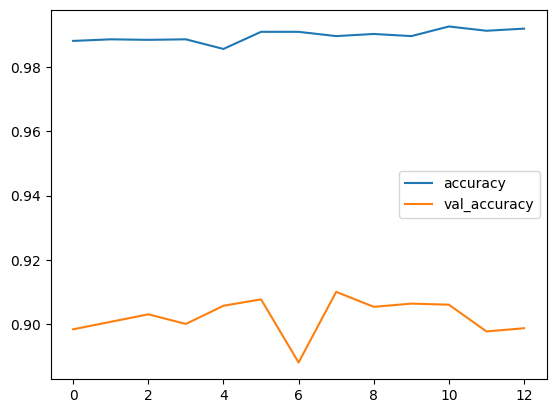

In [ ]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

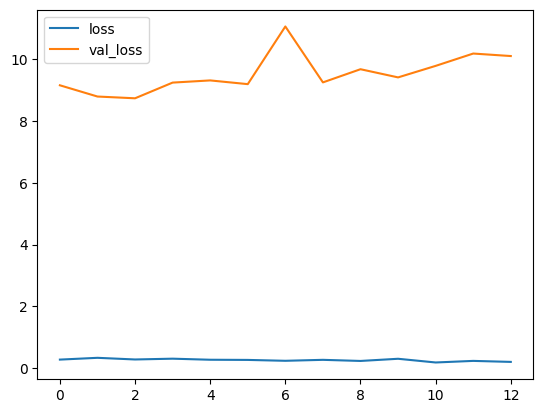

In [ ]:
metrics[['loss','val_loss']].plot()
plt.show()

report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_transfere_learning_feature_extraction.keras). Were you able to beat the benchmark? by how much? (10 points)

4. Now it is time to do transfer learning with fine-tuning a pretrained model.






Whatever model architecture you picked from keras.api (vgg16, exception or etc), make sure you unfreeze the last 4 layers (or any other number depending on the model you chose). (5 points)

create your own neural network! (the input of this dense network is the same as your original input image (180*180*3) because we are fine-tuning our own model.  (10 points)

report the model.summary(). How many parameters does not NN architecture has? how many of the are trainable and how many are no-trainable? (5 points)

train your model using model.fit(). Make sure you save the best one by adding the modelcheckpoint to your callback list. (5 points)

plot the loss vs epoch graph! as well as accuracy vs epoch graph. (10 points)

report the test set accuracy of your best performing model (the one that you saved by using the modelcheckpoint in the previous step. You might have named it as CNN_transfere_learning_fine_tuning.keras). Were you able to beat the benchmark? how about beating the feature extraction model? (10 points)

5. Excellent job my friend! Now let's have some fun. Can you go ahead and visualize 9 images from the test set that the model misclassified? What is your accuracy (as human being) on these 9 misclassified images by the machine!